In [1]:
import gdal
import folium
from folium import raster_layers
from folium import features
import urllib.request
import xarray as xr
import numpy as np
import time
from datetime import datetime, date, time, timedelta
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
#read in USV data
file_dir = 'F:/data/cruise_data/saildrone/2019_arctic/daily_files/*.nc'
ds_usv = xr.open_mfdataset(file_dir,data_vars='minimal')
ds_usv.load()

<xarray.Dataset>
Dimensions:                     (obs: 97068, trajectory: 2)
Coordinates:
  * trajectory                  (trajectory) float64 1.036e+03 1.037e+03
    time                        (trajectory, obs) datetime64[ns] 2019-05-14T18:12:00 ... 2019-06-18T23:59:00
    latitude                    (trajectory, obs) float64 nan 53.84 ... 71.07
    longitude                   (trajectory, obs) float64 nan -166.6 ... -162.4
Dimensions without coordinates: obs
Data variables:
    SOG                         (trajectory, obs) float64 0.001 0.002 ... 0.045
    SOG_FILTERED_MEAN           (trajectory, obs) float64 0.0 0.01 ... 0.028
    SOG_FILTERED_STDDEV         (trajectory, obs) float64 0.0 0.027 ... 0.013
    SOG_FILTERED_MAX            (trajectory, obs) float64 0.001 0.136 ... 0.052
    SOG_FILTERED_MIN            (trajectory, obs) float64 0.0 0.0 ... 0.006
    COG                         (trajectory, obs) float64 12.1 315.2 ... 44.9
    COG_FILTERED_MEAN           (trajectory, obs)

In [2]:
#not useing this right now but consider putting instance here
def get_key(file_name):
    myvars = {}
    with open(file_name) as myfile:
        for line in myfile:
            name, var = line.partition("=")[::2]
            myvars[name.strip()] = str(var).rstrip()
    return myvars

my_vars = get_key("C:/Users/gentemann/Google Drive/f_drive/sentinelhub_bingkun.txt")


In [3]:

endtime = datetime.today().strftime('%Y-%m-%d')
starttime = (datetime.today() + timedelta(days=-5)).strftime('%Y-%m-%d')

#set time
#starttime='2019-06-14'
#endtime=now #'2019-06-19'
#url = 'https://services.sentinel-hub.com/ogc/wms/'+my_vars["instance"]+'?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX=73.00556612657772%2C-150.41441917419436%2C67.9197529862965%2C-182.05504417419436&evalscriptoverrides=&LAYERS=EW-DH-HH-DECIBEL-GAMMA0-ORTHORECTIFIED&WIDTH=2752&HEIGHT=1330&NICENAME=S1.tiff&COVERAGE' 
#url = 'https://services.sentinel-hub.com/ogc/wms/5887863d-3c49-4c96-8c62-afc13dd8a04a?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX=73.00556612657772%2C-150.41441917419436%2C67.9197529862965%2C-182.05504417419436&evalscriptoverrides=&LAYERS=EW-DH-HH-DECIBEL-GAMMA0-ORTHORECTIFIED&WIDTH=2752&HEIGHT=1330&NICENAME=S1.tiff&COVERAGE' 
url = 'https://services.sentinel-hub.com/ogc/wms/ed64bf38-72da-4723-9c06-568b76b8add0?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX=74.0%2C-153.0%2C69.0%2C-170.0&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=4076&HEIGHT=1989&NICENAME=S1.tiff&COVERAGE' 
#url = 'https://services.sentinel-hub.com/ogc/wms/ed64bf38-72da-4723-9c06-568b76b8add0?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A3857&FORMAT=image%2Ftiff%3Bdepth%3D32f&BBOX=-19258571%2C10837032%2C-17304011%2C11944872&evalscriptoverrides=&LAYERS=6-SWIR&WIDTH=3054&HEIGHT=1731&NICENAME=Sentinel-2+L2A+from+2019-06-16.tiff&COVERAGE'
urllib.request.urlretrieve(url,'S11.tiff')  
    
#If you want 3857 format, just change the link into
#https://services.sentinel-hub.com/ogc/wms/5887863d-3c49-4c96-8c62-afc13dd8a04a?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME=2019-06-14%2F2019-06-14&CRS=EPSG%3A3857&FORMAT=image%2Fpng&BBOX=-20205487%2C10411576%2C-16682927%2C12108856&evalscriptoverrides=&LAYERS=EW-DH-HH-DECIBEL-GAMMA0-ORTHORECTIFIED&WIDTH=2752&HEIGHT=1326&NICENAME=Sentinel-1+AWS+%28S1-AWS-EW-HHHV%29+from+2019-06-14.png&TRANSPARENT=0&BGCOLOR=00000000

#Open S1 ice file
driver=gdal.GetDriverByName('GTiff')
driver.Register() 
ds = gdal.Open('S11.tiff') 
if ds is None:
    print('Could not open the Copernicus Sentinel-1 ice data')

geotransform = ds.GetGeoTransform()
cols = ds.RasterXSize 
rows = ds.RasterYSize 
xmin=geotransform[0]
ymax=geotransform[3]
xmax=xmin+cols*geotransform[1]
ymin=ymax+rows*geotransform[5]
centerx=(xmin+xmax)/2
centery=(ymin+ymax)/2

#Raster convert to array in numpy
bands = ds.RasterCount
band=ds.GetRasterBand(1)
dataimage= band.ReadAsArray(0,0,cols,rows)


#Visualization in folium
map= folium.Map(location=[centery, centerx], zoom_start=7,tiles='Stamen Terrain')
raster_layers.ImageOverlay(
    image=dataimage,
    bounds=[[ymin, xmin], [ymax, xmax]],
    colormap=lambda x: (0, 0, 0, x),#R,G,B,alpha
    #if I want white background then R,G,B is 1,1,1 
).add_to(map)

#add each saildrone individually
for itrag in range(0,ds_usv.trajectory.size):
    loc = []
    subset = ds_usv.isel(trajectory=itrag).swap_dims({'obs':'time'})
    subset = subset.where(np.isfinite(subset.longitude),drop=True)
    subset = subset.sel(time=slice(starttime,endtime))
    for iobs in range(subset.time.size):
        if np.isnan(subset.latitude[iobs].data):
            continue
        loc.append([float(subset.latitude[iobs].data),float(subset.longitude[iobs].data)])
    if len(loc)>0:
        saildrone_path= folium.PolyLine(locations=loc,color='red',weight=1,opacity=.5,popup=ds_usv.trajectory[itrag]) #assume the path of Saildrone
        saildrone_path.add_to(map) #put the path into map

#Save the final plot
map.save('C:/Users/gentemann/Google Drive/public/saildrone/seaice_with_saildronepath.html')    
    


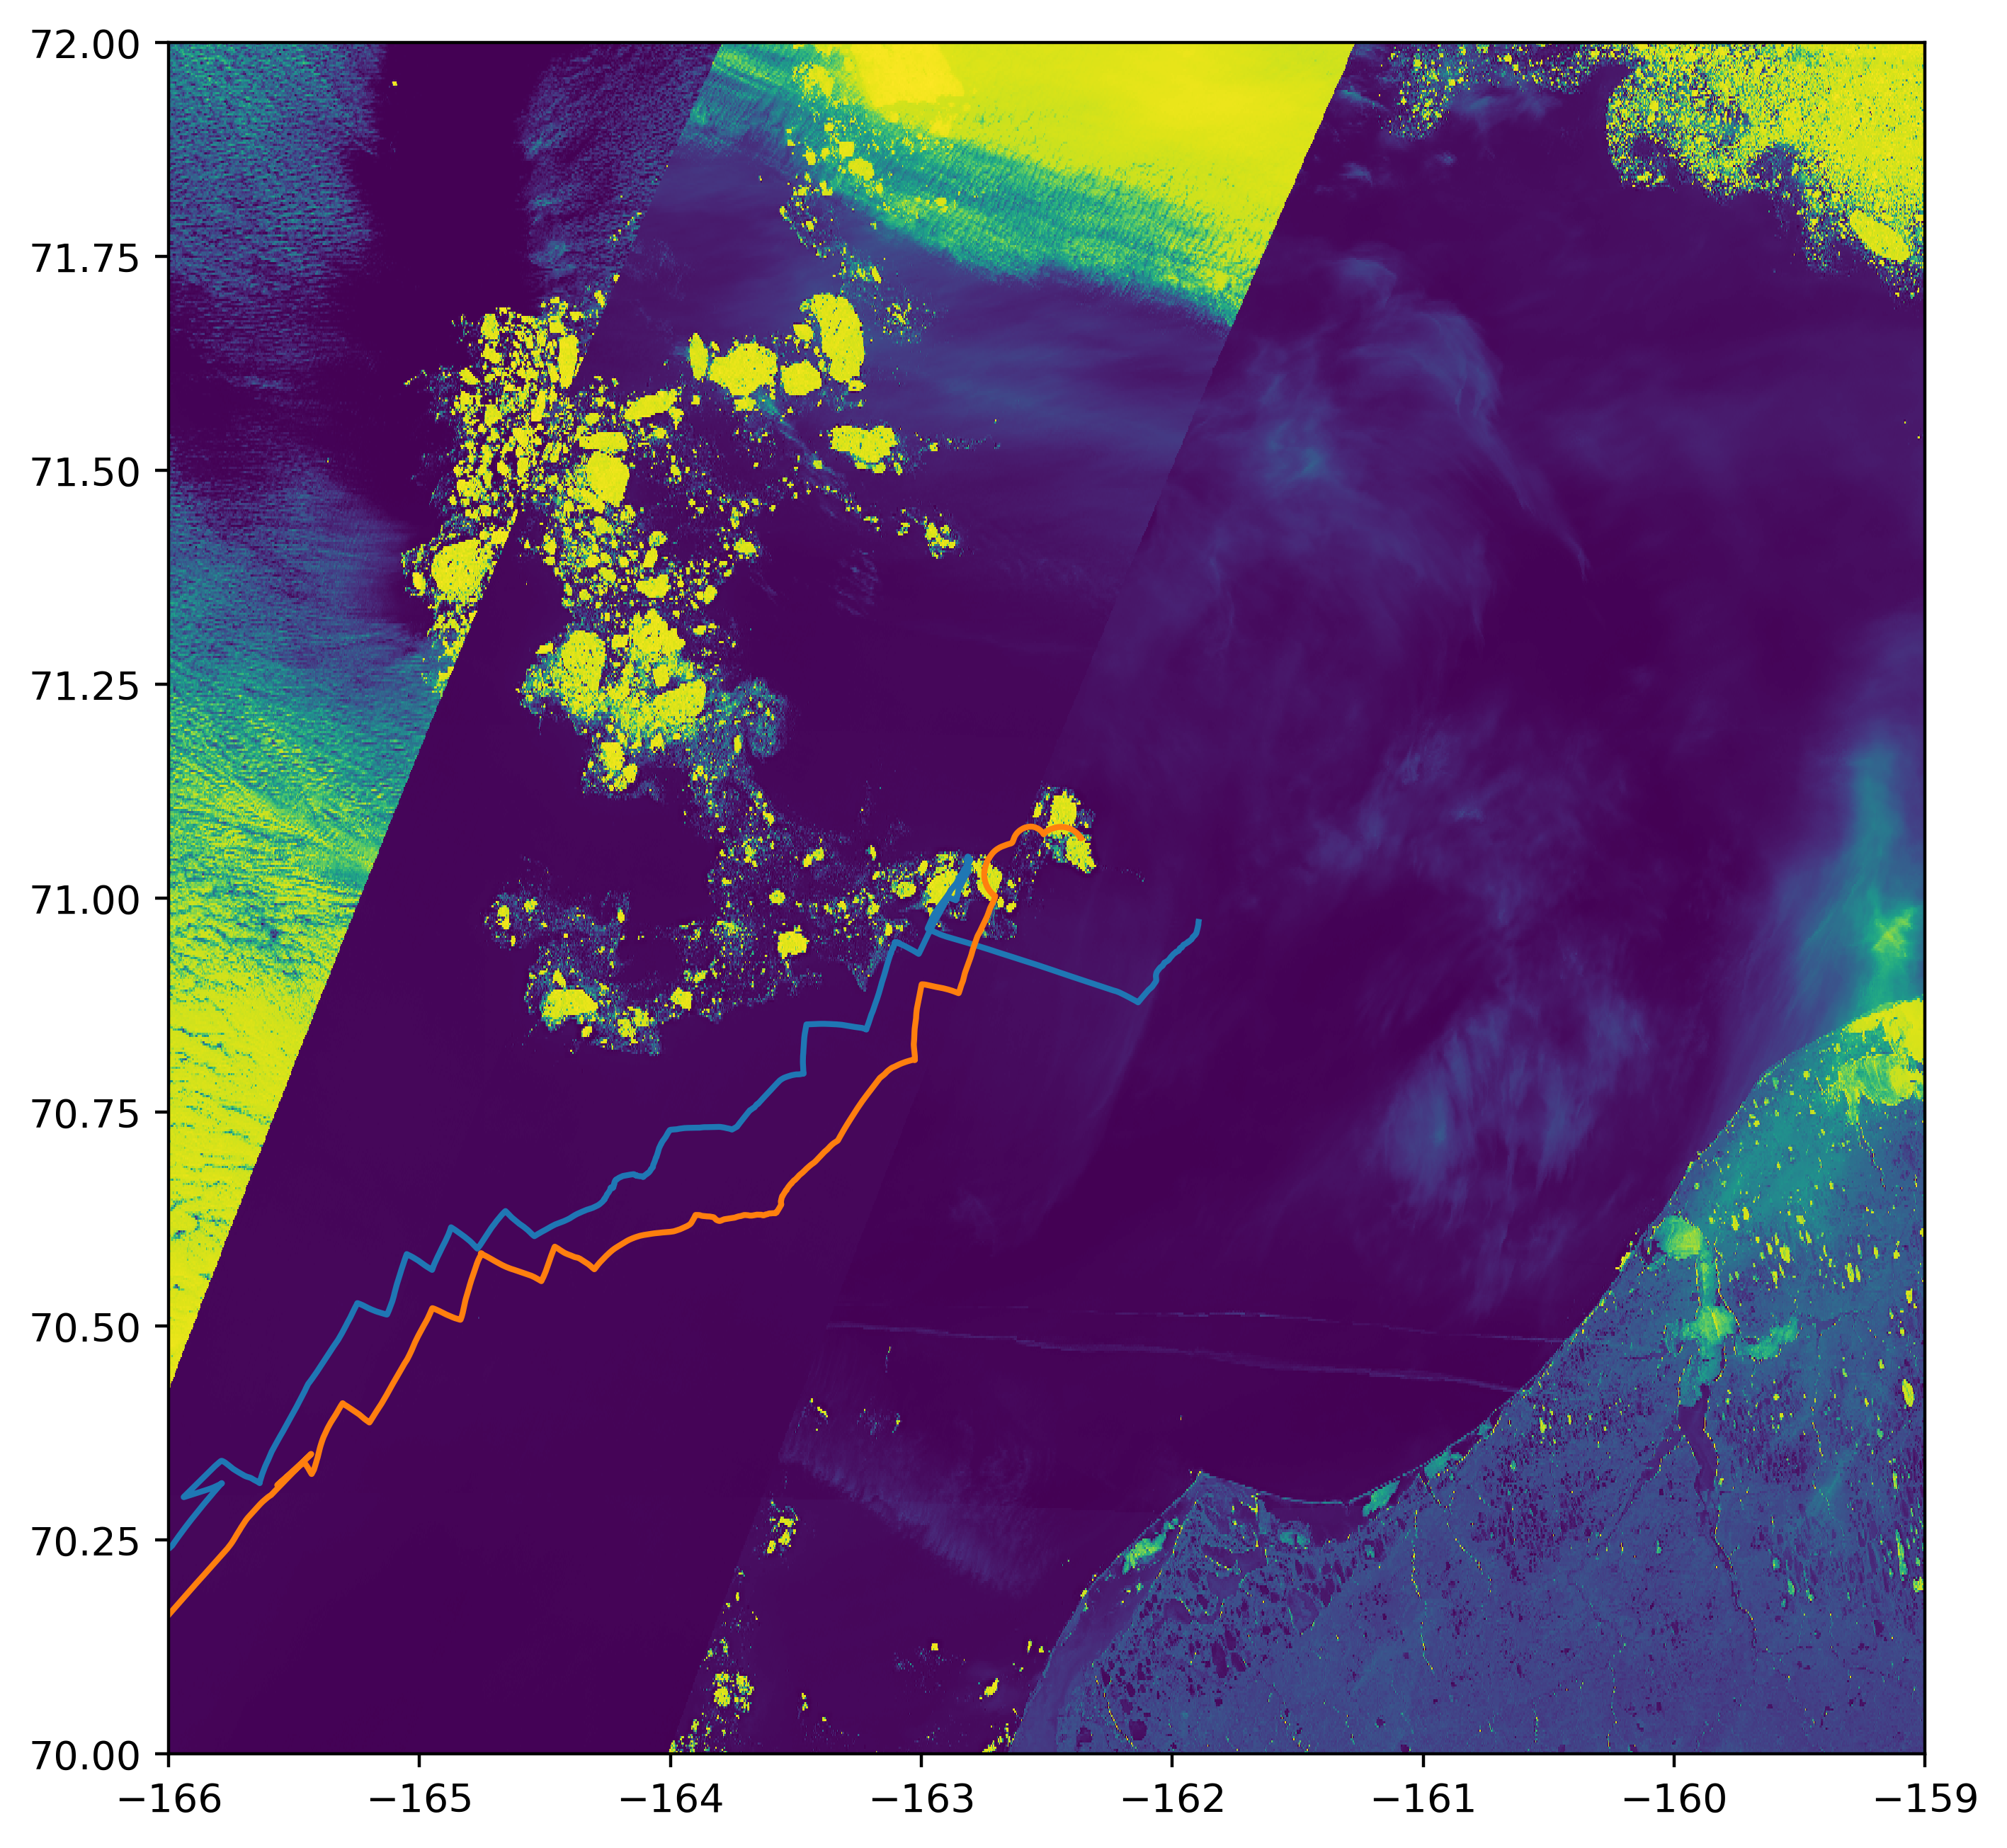

In [123]:
print(xmin,xmax,ymin,ymax)
xx=xmin+np.arange(dataimage.shape[1])/dataimage.shape[1]*(xmax-xmin)
yy=ymin+np.arange(dataimage.shape[0])/dataimage.shape[0]*(ymax-ymin)
print(xx.shape,yy.shape)
print(xx[0],xx[-1],yy[0],yy[-1])
figure(figsize=(8, 8), dpi=400)
plt.pcolormesh(xx,yy,dataimage[-1:0:-1,:])
plt.xlim(-166,-159)
plt.ylim(70,72)
for itrag in range(0,ds_usv.trajectory.size):
    loc = []
    subset = ds_usv.isel(trajectory=itrag).swap_dims({'obs':'time'})
    subset = subset.where(np.isfinite(subset.longitude),drop=True)
    subset = subset.sel(time=slice(starttime,endtime))
    plt.plot(subset.longitude,subset.latitude,label=str(ds_usv.trajectory[itrag]))


In [124]:
endtime = datetime.today().strftime('%Y-%m-%d')
starttime = (datetime.today() + timedelta(days=-3)).strftime('%Y-%m-%d')

#use usv data to calculate bounding box
itrag=0
subset = ds_usv.isel(trajectory=itrag).swap_dims({'obs':'time'})
subset = subset.where(np.isfinite(subset.longitude),drop=True)
subset = subset.sel(time=slice(starttime,endtime))
lonmin,lonmax = str(subset.longitude.min().data-.2),str(subset.longitude.max().data+.2)
latmin,latmax = str(subset.latitude.min().data-.2),str(subset.latitude.max().data+.2)
print(lonmin,lonmax,latmin,latmax)

#url = 'https://services.sentinel-hub.com/ogc/wms/'+my_vars["instance"]+'?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX=73.00556612657772%2C-150.41441917419436%2C67.9197529862965%2C-182.05504417419436&evalscriptoverrides=&LAYERS=EW-DH-HH-DECIBEL-GAMMA0-ORTHORECTIFIED&WIDTH=2752&HEIGHT=1330&NICENAME=S1.tiff&COVERAGE' 
#url = 'https://services.sentinel-hub.com/ogc/wms/5887863d-3c49-4c96-8c62-afc13dd8a04a?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX=73.00556612657772%2C-150.41441917419436%2C67.9197529862965%2C-182.05504417419436&evalscriptoverrides=&LAYERS=EW-DH-HH-DECIBEL-GAMMA0-ORTHORECTIFIED&WIDTH=2752&HEIGHT=1330&NICENAME=S1.tiff&COVERAGE' 
url = 'https://services.sentinel-hub.com/ogc/wms/ed64bf38-72da-4723-9c06-568b76b8add0?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX='+latmax+'%2C'+lonmax+'%2C'+latmin+'%2C'+lonmin+'&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=4076&HEIGHT=1989&NICENAME=S1.tiff&COVERAGE' 
#url = 'https://services.sentinel-hub.com/ogc/wms/ed64bf38-72da-4723-9c06-568b76b8add0?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A3857&FORMAT=image%2Ftiff%3Bdepth%3D32f&BBOX=-19258571%2C10837032%2C-17304011%2C11944872&evalscriptoverrides=&LAYERS=6-SWIR&WIDTH=3054&HEIGHT=1731&NICENAME=Sentinel-2+L2A+from+2019-06-16.tiff&COVERAGE'
print(url)
urllib.request.urlretrieve(url,'S11.tiff')  
    
#If you want 3857 format, just change the link into
#https://services.sentinel-hub.com/ogc/wms/5887863d-3c49-4c96-8c62-afc13dd8a04a?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME=2019-06-14%2F2019-06-14&CRS=EPSG%3A3857&FORMAT=image%2Fpng&BBOX=-20205487%2C10411576%2C-16682927%2C12108856&evalscriptoverrides=&LAYERS=EW-DH-HH-DECIBEL-GAMMA0-ORTHORECTIFIED&WIDTH=2752&HEIGHT=1326&NICENAME=Sentinel-1+AWS+%28S1-AWS-EW-HHHV%29+from+2019-06-14.png&TRANSPARENT=0&BGCOLOR=00000000

#Open S1 ice file
driver=gdal.GetDriverByName('GTiff')
driver.Register() 
ds = gdal.Open('S11.tiff') 
if ds is None:
    print('Could not open the Copernicus Sentinel-1 ice data')

geotransform = ds.GetGeoTransform()
cols = ds.RasterXSize 
rows = ds.RasterYSize 
xmin=geotransform[0]
ymax=geotransform[3]
xmax=xmin+cols*geotransform[1]
ymin=ymax+rows*geotransform[5]
centerx=(xmin+xmax)/2
centery=(ymin+ymax)/2

#Raster convert to array in numpy
bands = ds.RasterCount
band=ds.GetRasterBand(1)
dataimage= band.ReadAsArray(0,0,cols,rows)


-164.42877439999998 -161.69521920000003 70.4615488 71.2486976
https://services.sentinel-hub.com/ogc/wms/ed64bf38-72da-4723-9c06-568b76b8add0?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME=2019-06-16%2F2019-06-19&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX=71.2486976%2C-161.69521920000003%2C70.4615488%2C-164.42877439999998&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=4076&HEIGHT=1989&NICENAME=S1.tiff&COVERAGE


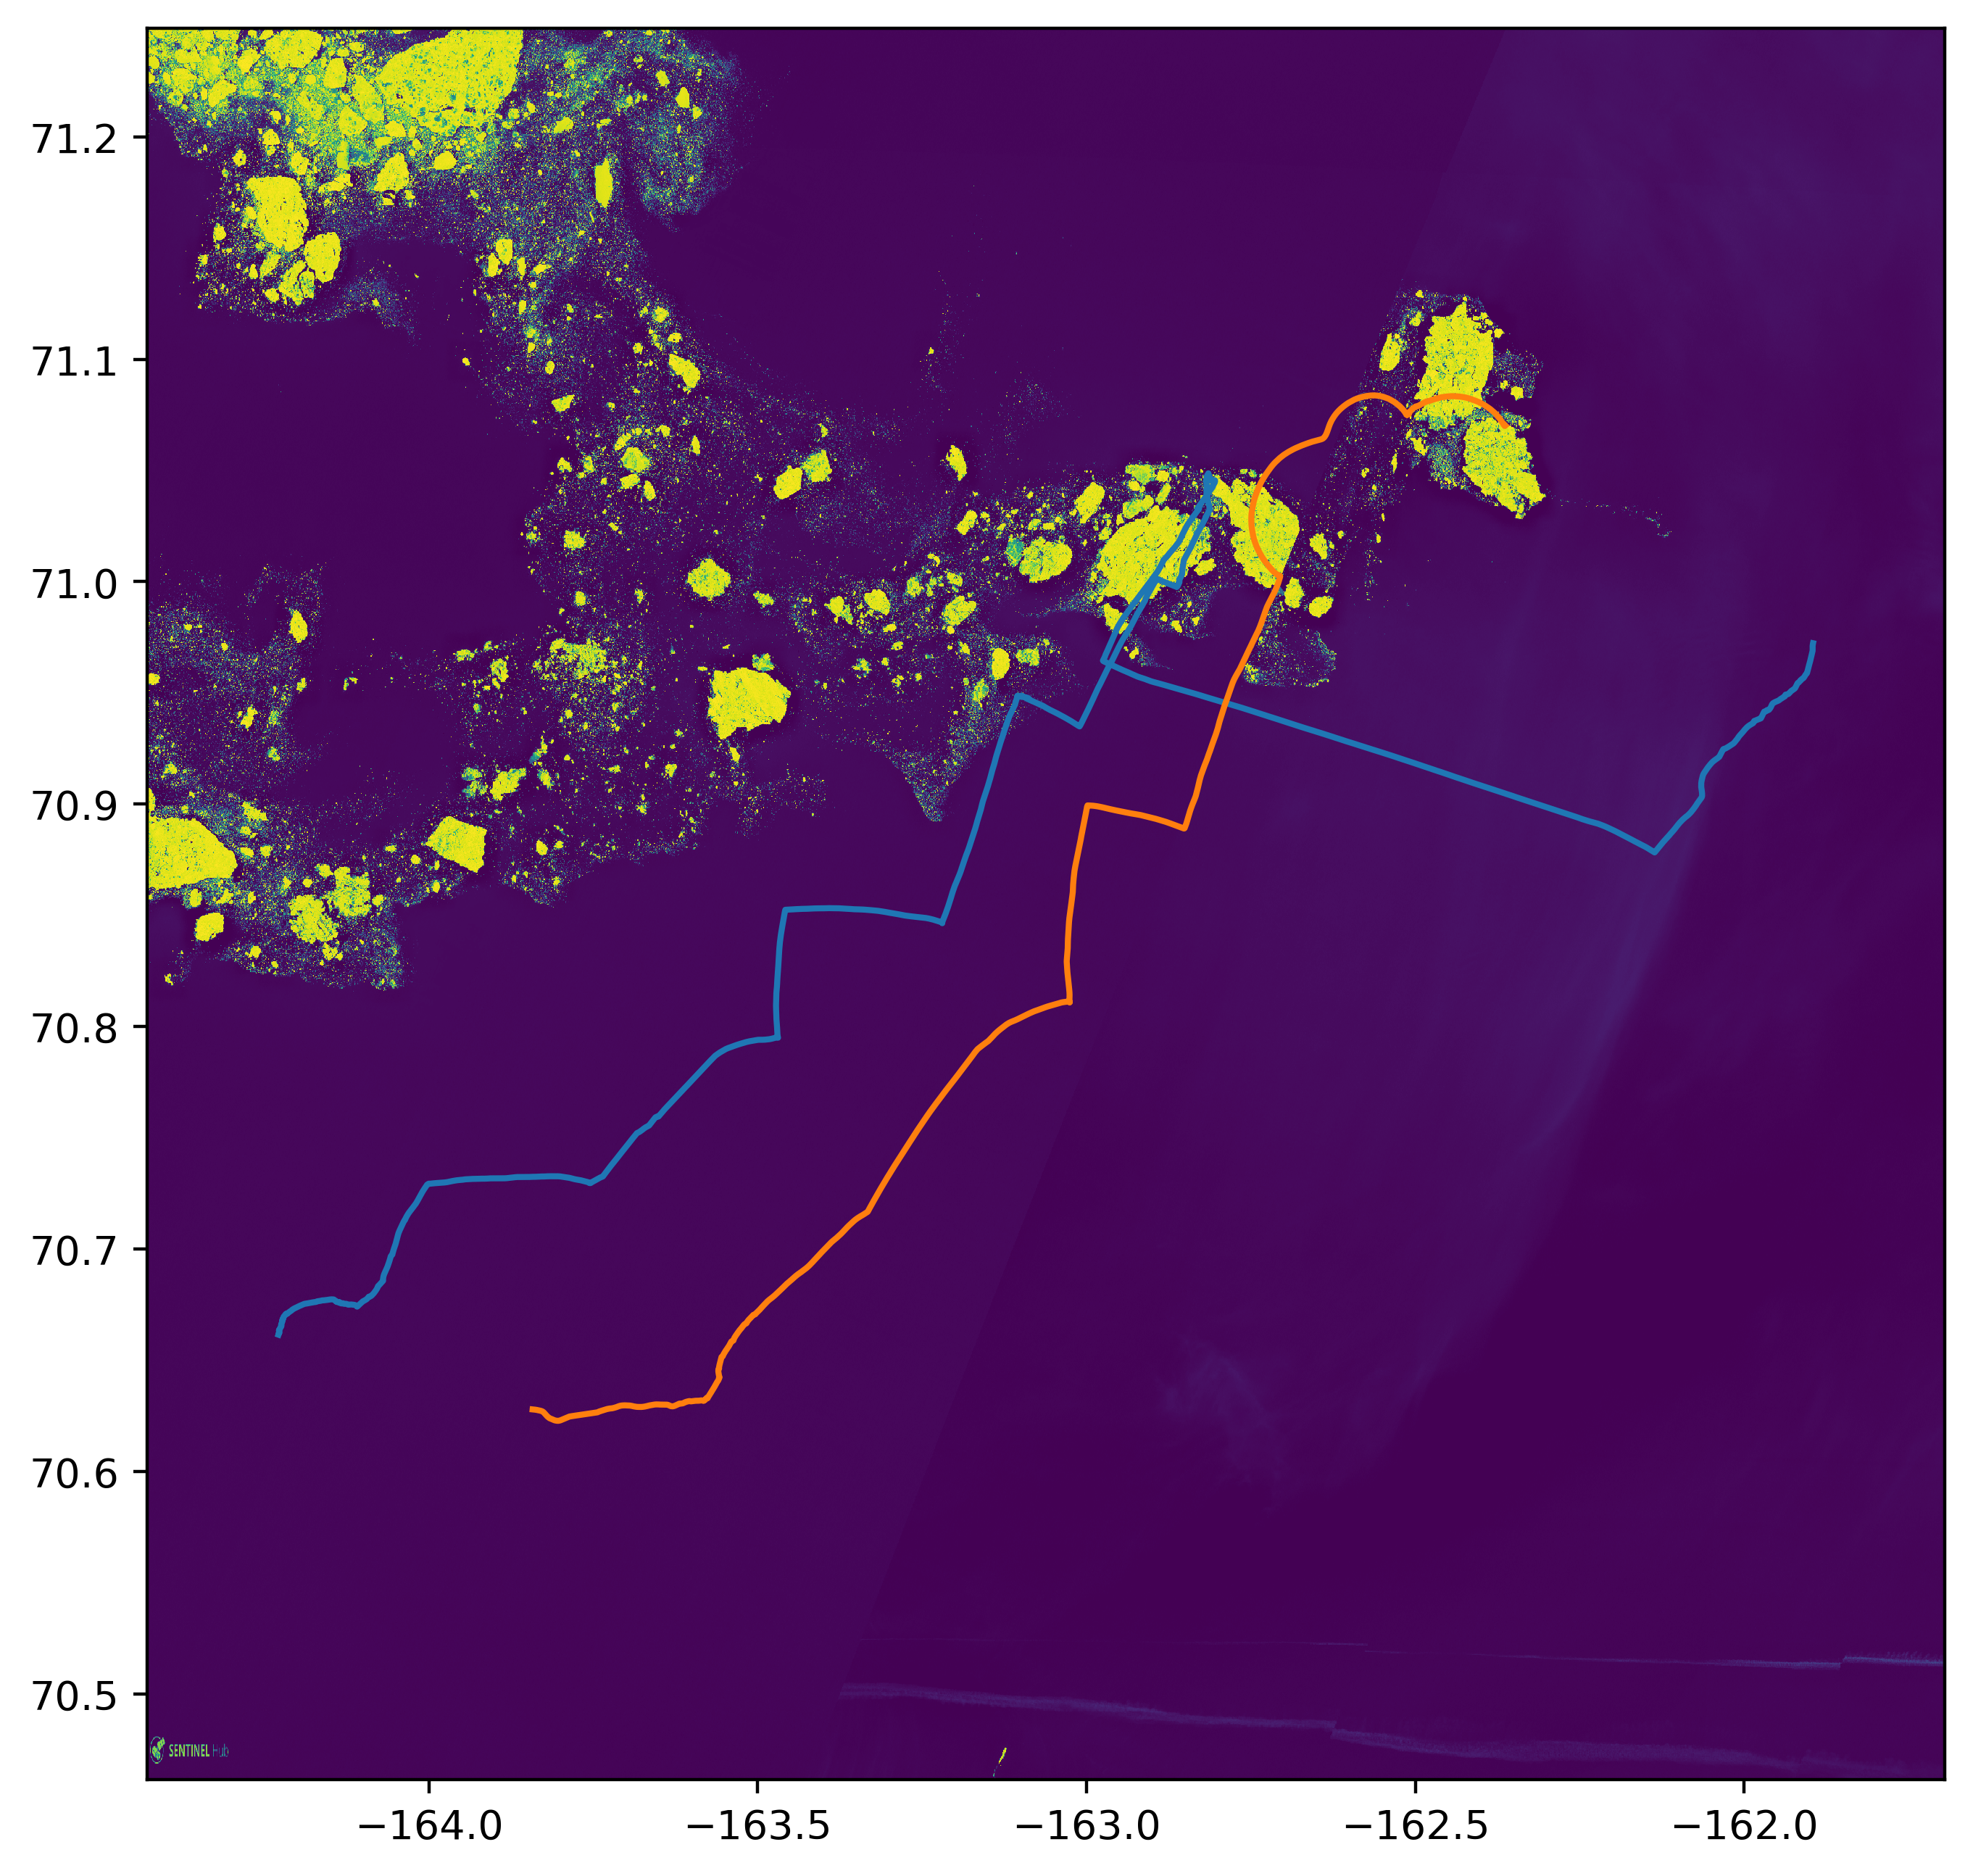

In [137]:
print(xmin,xmax,ymin,ymax)
xx=xmin+np.arange(dataimage.shape[1])/dataimage.shape[1]*(xmax-xmin)
yy=ymin+np.arange(dataimage.shape[0])/dataimage.shape[0]*(ymax-ymin)
print(xx.shape,yy.shape)
print(xx[0],xx[-1],yy[0],yy[-1])figure(figsize=(8, 8), dpi=400)
plt.pcolormesh(xx,yy,dataimage[-1:0:-1,:])
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
for itrag in range(0,ds_usv.trajectory.size):
    loc = []
    subset = ds_usv.isel(trajectory=itrag).swap_dims({'obs':'time'})
    subset = subset.where(np.isfinite(subset.longitude),drop=True)
    subset = subset.sel(time=slice(starttime,endtime))
    plt.plot(subset.longitude,subset.latitude,label=str(ds_usv.trajectory[itrag]))


In [199]:
#do again, but zoomed to saildrone sampling region

#set start and end time
endtime = datetime.today().strftime('%Y-%m-%d')
starttime = (datetime.today() + timedelta(days=-3)).strftime('%Y-%m-%d')

#use usv data to calculate bounding box
itrag=0
subset = ds_usv.isel(trajectory=itrag).swap_dims({'obs':'time'})
subset = subset.where(np.isfinite(subset.longitude),drop=True)
subset = subset.sel(time=slice(starttime,endtime))
lonmin,lonmax = str(subset.longitude.min().data-.2),str(subset.longitude.max().data+.2)
latmin,latmax = str(subset.latitude.min().data-.2),str(subset.latitude.max().data+.2)
print(lonmin,lonmax,latmin,latmax)

#url = 'https://services.sentinel-hub.com/ogc/wms/'+my_vars["instance"]+'?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX=73.00556612657772%2C-150.41441917419436%2C67.9197529862965%2C-182.05504417419436&evalscriptoverrides=&LAYERS=EW-DH-HH-DECIBEL-GAMMA0-ORTHORECTIFIED&WIDTH=2752&HEIGHT=1330&NICENAME=S1.tiff&COVERAGE' 
#url = 'https://services.sentinel-hub.com/ogc/wms/5887863d-3c49-4c96-8c62-afc13dd8a04a?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX=73.00556612657772%2C-150.41441917419436%2C67.9197529862965%2C-182.05504417419436&evalscriptoverrides=&LAYERS=EW-DH-HH-DECIBEL-GAMMA0-ORTHORECTIFIED&WIDTH=2752&HEIGHT=1330&NICENAME=S1.tiff&COVERAGE' 
url = 'https://services.sentinel-hub.com/ogc/wms/ed64bf38-72da-4723-9c06-568b76b8add0?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX='+latmax+'%2C'+lonmax+'%2C'+latmin+'%2C'+lonmin+'&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=4076&HEIGHT=1989&NICENAME=S1.tiff&COVERAGE' 
#url = 'https://services.sentinel-hub.com/ogc/wms/ed64bf38-72da-4723-9c06-568b76b8add0?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME='+starttime+'%2F'+endtime+'&CRS=EPSG%3A3857&FORMAT=image%2Ftiff%3Bdepth%3D32f&BBOX=-19258571%2C10837032%2C-17304011%2C11944872&evalscriptoverrides=&LAYERS=6-SWIR&WIDTH=3054&HEIGHT=1731&NICENAME=Sentinel-2+L2A+from+2019-06-16.tiff&COVERAGE'
print(url)
urllib.request.urlretrieve(url,'S11.tiff')  
    
#If you want 3857 format, just change the link into
#https://services.sentinel-hub.com/ogc/wms/5887863d-3c49-4c96-8c62-afc13dd8a04a?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME=2019-06-14%2F2019-06-14&CRS=EPSG%3A3857&FORMAT=image%2Fpng&BBOX=-20205487%2C10411576%2C-16682927%2C12108856&evalscriptoverrides=&LAYERS=EW-DH-HH-DECIBEL-GAMMA0-ORTHORECTIFIED&WIDTH=2752&HEIGHT=1326&NICENAME=Sentinel-1+AWS+%28S1-AWS-EW-HHHV%29+from+2019-06-14.png&TRANSPARENT=0&BGCOLOR=00000000

#Open S1 ice file
driver=gdal.GetDriverByName('GTiff')
driver.Register() 
ds = gdal.Open('S11.tiff') 
if ds is None:
    print('Could not open the Copernicus Sentinel-1 ice data')

geotransform = ds.GetGeoTransform()
cols = ds.RasterXSize 
rows = ds.RasterYSize 
xmin=geotransform[0]
ymax=geotransform[3]
xmax=xmin+cols*geotransform[1]
ymin=ymax+rows*geotransform[5]
centerx=(xmin+xmax)/2
centery=(ymin+ymax)/2

#Raster convert to array in numpy
bands = ds.RasterCount
band=ds.GetRasterBand(1)
dataimage= band.ReadAsArray(0,0,cols,rows)


#Visualization in folium
map= folium.Map(location=[centery, centerx], zoom_start=7,tiles='Stamen Terrain')
raster_layers.ImageOverlay(
    image=dataimage,
    bounds=[[ymin, xmin], [ymax, xmax]],
    colormap=lambda x: (0, 0, 0, x),#R,G,B,alpha
    #if I want white background then R,G,B is 1,1,1 
).add_to(map)

#add each saildrone individually
for itrag in range(0,ds_usv.trajectory.size):
    loc = []
    subset = ds_usv.isel(trajectory=itrag).swap_dims({'obs':'time'})
    subset = subset.where(np.isfinite(subset.longitude),drop=True)
    subset = subset.sel(time=slice(starttime,endtime))
    for iobs in range(subset.time.size):
        if np.isnan(subset.latitude[iobs].data):
            continue
        loc.append([float(subset.latitude[iobs].data),float(subset.longitude[iobs].data)])
    if len(loc)>0:
        saildrone_path= folium.PolyLine(locations=loc,color='red',weight=1,opacity=.5,popup=ds_usv.trajectory[itrag]) #assume the path of Saildrone
        saildrone_path.add_to(map) #put the path into map

#Save the final plot
map.save('C:/Users/gentemann/Google Drive/public/saildrone/seaice_with_saildronepath_zoom.html')    
    


-164.42877439999998 -161.69521920000003 70.4615488 71.2486976
https://services.sentinel-hub.com/ogc/wms/ed64bf38-72da-4723-9c06-568b76b8add0?SERVICE=WMS&REQUEST=GetMap&SHOWLOGO=true&MAXCC=100&TIME=2019-06-16%2F2019-06-19&CRS=EPSG%3A4326&FORMAT=image%2Ftiff%3Bdepth%3D8&BBOX=71.2486976%2C-161.69521920000003%2C70.4615488%2C-164.42877439999998&evalscriptoverrides=&LAYERS=1_TRUE_COLOR&WIDTH=4076&HEIGHT=1989&NICENAME=S1.tiff&COVERAGE


In [201]:
ds_usv.to_netcdf('C:/Users/gentemann/Google Drive/public/saildrone/cruise.nc')